# Recursive Forecasting
25 March 2024  
Conda environment: `time-series`

In [74]:
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd

from sklearn import set_config
from sklearn.base import clone
from sklearn.pipeline import make_pipeline, make_union
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
from sktime.transformations.series.summarize import WindowSummarizer
from sktime.transformations.series.time_since import TimeSince

from sklearn.linear_model import Lasso, LinearRegression, Ridge, ElasticNet

from sklearn.metrics import mean_squared_error

In [75]:
# Configs

# Plot configs:
sns.set_context("paper", font_scale= 1.5)
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
plotsize = (22, 5)
plt.rcParams['figure.figsize'] = plotsize

# Pandas config
pd.options.display.float_format = '{:,.4f}'.format
pd.options.display.max_columns = 200

# Output a pandas df intead of numpy
set_config(transform_output="pandas")

In [76]:
# Functions
def c_mape(y: pd.Series, y_hat: pd.Series) -> np.float64:
    """
    Implements Mean Absolute Percent Error (MAPE).
    Args:
        y: actual values.
        y_hat: predicted values.
    Returns:
        MAPE value (Not in %)
    """
    if not (isinstance(y, pd.Series) and isinstance(y_hat, pd.Series)):
        y, y_hat = pd.Series(y), pd.Series(y_hat)
    mape = np.mean(np.abs((y - y_hat) / y))
    return np.round(mape, 4)

## 1) Input data

In [77]:
data = pd.read_csv(
    "../Datasets/example_air_passengers.csv",
    parse_dates=["ds"],
    index_col=["ds"],
)

data

,y
ds,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121
...,...
1960-08-01,606
1960-09-01,508
1960-10-01,461


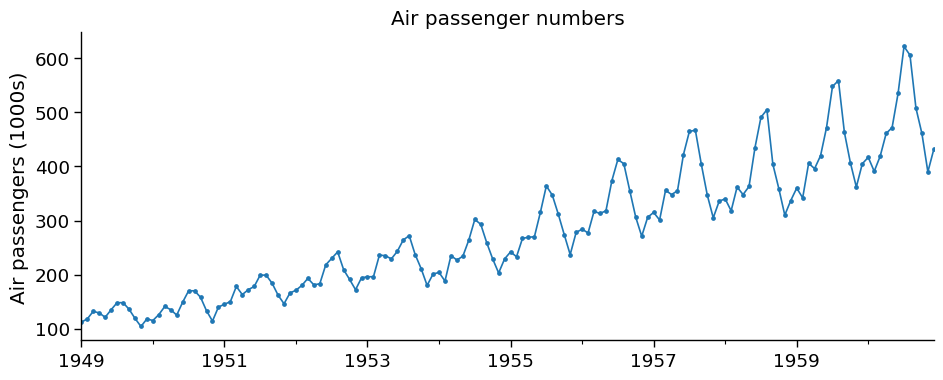

In [78]:
data.plot(y="y", marker=".", figsize=[11, 4], legend=None)

plt.ylabel("Air passengers (1000s)")
plt.xlabel("")
plt.title("Air passenger numbers")

plt.show()

## 2) Features

In [79]:
df = data.copy()
df.head()

,y
ds,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [80]:
target = ["y"]

# Polynomial time features
time_feats = make_pipeline(
    TimeSince(freq="MS"),
    PolynomialFeatures(degree=2, include_bias=False)
)

# Compute lag and window features.
lag_window_feats = WindowSummarizer(
    lag_feature={
        "lag": [1, 2, 3, 12],  # Lag features.
        "mean": [[1, 12]],  # [[lag, window size]]
        "kurt": [[1, 12]],
    },
    target_cols=target,
    truncate="bfill",  # Backfill missing values from lagging and windowing.
)

# Create the Pipeline
pipeline = make_union(time_feats, lag_window_feats)

# Apply min-max scaling to all the features
pipeline = make_pipeline(pipeline, MinMaxScaler())
pipeline

Pipeline(steps=[('featureunion',
                 FeatureUnion(transformer_list=[('pipeline',
                                                 Pipeline(steps=[('timesince',
                                                                  TimeSince(freq='MS')),
                                                                 ('polynomialfeatures',
                                                                  PolynomialFeatures(include_bias=False))])),
                                                ('windowsummarizer',
                                                 WindowSummarizer(lag_feature={'kurt': [[1, 12]], 'lag': [1, 2, 3, 12],
                              'mean': [[1, 12]]},
                 target_cols=['y'], truncate='bfill'))])),
                ('minmaxscaler', MinMaxScaler())])

In [81]:
# Let's explore our pipeline
pipeline.fit_transform(df)

,time_since_1949-01-01 00:00:00,time_since_1949-01-01 00:00:00^2,y_lag_1,y_lag_2,y_lag_3,y_lag_12,y_mean_1_12,y_kurt_1_12
ds,,,,,,,,
1949-01-01,0.0000,0.0000,0.0154,0.0154,0.0154,0.0176,0.0000,0.1821
1949-02-01,0.0070,0.0000,0.0154,0.0154,0.0154,0.0176,0.0000,0.1821
1949-03-01,0.0140,0.0002,0.0270,0.0154,0.0154,0.0176,0.0000,0.1821
1949-04-01,0.0210,0.0004,0.0541,0.0270,0.0154,0.0176,0.0000,0.1821
1949-05-01,0.0280,0.0008,0.0483,0.0541,0.0270,0.0176,0.0000,0.1821
...,...,...,...,...,...,...,...,...
1960-08-01,0.9720,0.9448,1.0000,0.8320,0.7104,1.0000,0.9583,0.6157
1960-09-01,0.9790,0.9585,0.9691,1.0000,0.8320,0.7890,0.9696,0.5052
1960-10-01,0.9860,0.9722,0.7799,0.9691,1.0000,0.6659,0.9803,0.3545


In [82]:
# We can use `clone` to return an unfitted version of the pipeline.
pipeline = clone(pipeline)
pipeline

Pipeline(steps=[('featureunion',
                 FeatureUnion(transformer_list=[('pipeline',
                                                 Pipeline(steps=[('timesince',
                                                                  TimeSince(freq='MS')),
                                                                 ('polynomialfeatures',
                                                                  PolynomialFeatures(include_bias=False))])),
                                                ('windowsummarizer',
                                                 WindowSummarizer(lag_feature={'kurt': [[1, 12]], 'lag': [1, 2, 3, 12],
                              'mean': [[1, 12]]},
                 target_cols=['y'], truncate='bfill'))])),
                ('minmaxscaler', MinMaxScaler())])

## 3) Forecast

In [83]:
forecast_start_time = pd.to_datetime("1958-01-01")
# Define number of steps to forecast.
num_of_forecast_steps = 36
# Horizon
forecast_horizon = pd.date_range(
    forecast_start_time, periods=num_of_forecast_steps, freq="MS"
)

forecast_horizon

DatetimeIndex(['1958-01-01', '1958-02-01', '1958-03-01', '1958-04-01',
               '1958-05-01', '1958-06-01', '1958-07-01', '1958-08-01',
               '1958-09-01', '1958-10-01', '1958-11-01', '1958-12-01',
               '1959-01-01', '1959-02-01', '1959-03-01', '1959-04-01',
               '1959-05-01', '1959-06-01', '1959-07-01', '1959-08-01',
               '1959-09-01', '1959-10-01', '1959-11-01', '1959-12-01',
               '1960-01-01', '1960-02-01', '1960-03-01', '1960-04-01',
               '1960-05-01', '1960-06-01', '1960-07-01', '1960-08-01',
               '1960-09-01', '1960-10-01', '1960-11-01', '1960-12-01'],
              dtype='datetime64[ns]', freq='MS')

In [84]:
# How much data in the past is needed to create our features: 12 because we are using lag 12, and mean window of 12
look_back_window_size = pd.DateOffset(months=12)

### 3.1) Train/Test split

In [85]:
df_train = df.loc[df.index < forecast_start_time].copy()
df_test = df.loc[df.index >= forecast_start_time].copy()

print(f"Train shape: {len(df_train)}")
print(f"Test shape: {len(df_test)}")

Train shape: 108
Test shape: 36


In [86]:
# Create X_train and y_train
y_train = df_train[target]
X_train = pipeline.fit_transform(df_train)
print(f"y_train: {len(y_train)}")
print(f"X_train: {len(X_train)}")

X_train.head()

y_train: 108
X_train: 108


,time_since_1949-01-01 00:00:00,time_since_1949-01-01 00:00:00^2,y_lag_1,y_lag_2,y_lag_3,y_lag_12,y_mean_1_12,y_kurt_1_12
ds,,,,,,,,
1949-01-01,0.0000,0.0000,0.0220,0.0220,0.0220,0.0259,0.0000,0.1821
1949-02-01,0.0093,0.0001,0.0220,0.0220,0.0220,0.0259,0.0000,0.1821
1949-03-01,0.0187,0.0003,0.0386,0.0220,0.0220,0.0259,0.0000,0.1821
1949-04-01,0.0280,0.0008,0.0771,0.0386,0.0220,0.0259,0.0000,0.1821
1949-05-01,0.0374,0.0014,0.0689,0.0771,0.0386,0.0259,0.0000,0.1821


In [87]:
X_train.tail()

,time_since_1949-01-01 00:00:00,time_since_1949-01-01 00:00:00^2,y_lag_1,y_lag_2,y_lag_3,y_lag_12,y_mean_1_12,y_kurt_1_12
ds,,,,,,,,
1957-08-01,0.9626,0.9266,0.9945,0.8760,0.6915,0.9741,0.9353,0.5208
1957-09-01,0.9720,0.9447,1.0000,0.9945,0.8760,0.8123,0.9569,0.3588
1957-10-01,0.9813,0.9630,0.8264,1.0000,0.9945,0.6537,0.9739,0.1668
1957-11-01,0.9907,0.9814,0.6694,0.8264,1.0000,0.5405,0.9882,0.2246
1957-12-01,1.0000,1.0000,0.5537,0.6694,0.8264,0.6537,1.0000,0.2098


In [88]:
# Define the model.
model = LinearRegression()
# SEED = 1
# model = Ridge(random_state=SEED)
# model = Lasso(random_state=SEED)
# model = ElasticNet(random_state=SEED, alpha=0.5, l1_ratio=0.5)

# Train one-step ahead forecast model
model.fit(X_train, y_train)

LinearRegression()

### 3.2) Recursive Multi-step Forecast

In [89]:
look_back_start_time = forecast_start_time - look_back_window_size

df_predict = df_train.loc[look_back_start_time:].copy()
# Extend index into forecast horizon
df_predict = pd.concat([df_predict, pd.DataFrame(index=forecast_horizon)])
print(f"Predict df: {len(df_predict)}")
df_predict.iloc[10:15]

Predict df: 48


,y
1957-11-01,305.0000
1957-12-01,336.0000
1958-01-01,NaN
1958-02-01,NaN
1958-03-01,NaN


In [90]:
# --- RECURSIVE FORECASTING LOOP --- #
for i in forecast_horizon:
    # Compute features during the forecast horizon
    X_test = pipeline.transform(df_predict[:i])
    X_test_ = X_test.loc[[i]]
    # Predict one step ahead.
    y_pred = model.predict(X_test_)
    # Append forecast to the target variable columnn in our dynamic forecast dataframe `df_predict`. 
    # This `df_predict` is ready for the next iteration where we will re-compute features derived from the target such as lags and windows.
    df_predict.loc[[i], target] = y_pred
    
# --- GET FORECAST AND TEST VALUES --- #
y_forecast = df_predict.loc[forecast_horizon, target]
y_test = df_test.loc[forecast_start_time:, target]

In [91]:
y_forecast.shape

(36, 1)

In [92]:
# --- CREATE IN-SAMPLE PREDICTIONS--- #
y_forecast_train = model.predict(X_train)
y_forecast_train = pd.DataFrame(y_forecast_train, index=X_train.index, columns=target)

### 3.3) Plot results

In [93]:
comp_forecast_real = pd.merge(
    left=y_forecast, 
    right=y_test, 
    left_index=True, 
    right_index=True).rename(columns={"y_x": "forecast", "y_y": "real"})

mape = c_mape(y=comp_forecast_real["real"], y_hat=comp_forecast_real["forecast"])
mse = mean_squared_error(y_test.loc[y_forecast.index], y_forecast, squared=False)

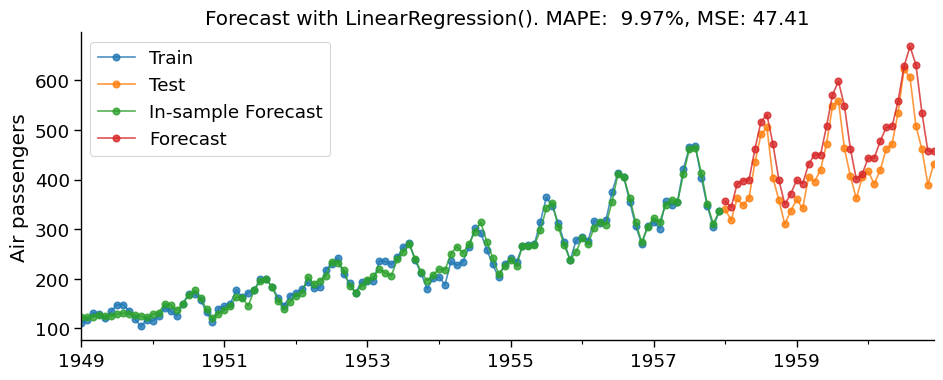

In [94]:
fig, ax = plt.subplots(figsize=[11, 4])

# Plot train/test data
y_train.plot(ax=ax, marker="o", alpha=0.8)
y_test.plot(ax=ax, marker="o", alpha=0.8)

# Plot Forecast
y_forecast_train.plot(ax=ax, marker="o", alpha=0.8)
y_forecast.plot(ax=ax, marker="o", alpha=0.8)


ax.set_title(f"Forecast with {model}. MAPE: {mape: .2%}, MSE: {mse:.2f}")
ax.legend(["Train", "Test", "In-sample Forecast", "Forecast"])
ax.set_xlabel("")
ax.set_ylabel(f"Air passengers")

plt.show()

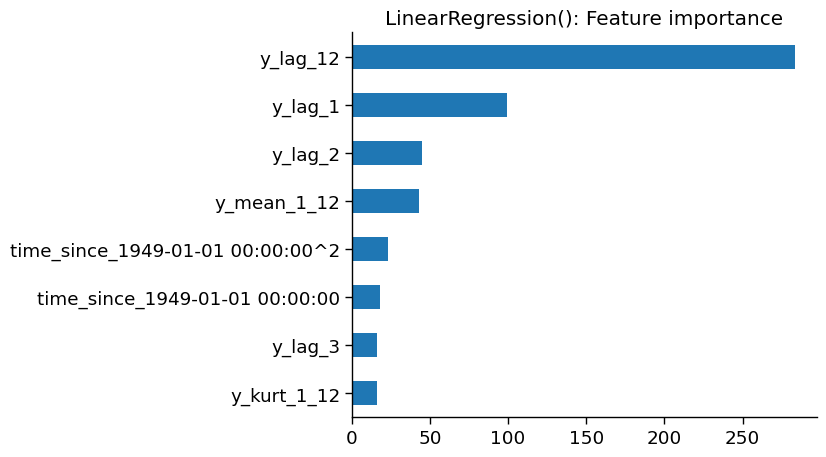

In [95]:
pd.Series(model.coef_[0], index=X_train.columns)\
    .abs()\
    .sort_values()\
    .plot(kind="barh", figsize=(6,5))

plt.title(f"{model}: Feature importance")
plt.show()